## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("/Users/gaganaananda/Downloads/movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

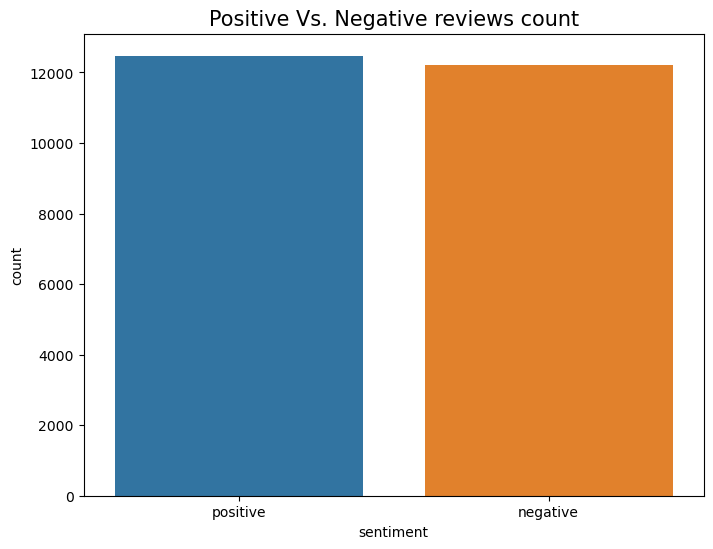

In [4]:
plt.figure(figsize = (8, 6))
sns.countplot(x = df['sentiment'])
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df.sentiment=='positive']
df_minority = df[df.sentiment=='negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority,negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled['sentiment']=='negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment']=='positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'],negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'],negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 
    '''
    stemmer = PorterStemmer()
    english_stopwords = stopwords.words('english') ## Removing stopwords
    
    rhtml = re.sub(r'<.*?>', '', review)
    review = re.sub(r'http\S+|www\S+|https\S+', '', rhtml, flags=re.MULTILINE) ## link
    review = re.sub(r'[^\w\s]', '', review)
    review = re.sub(r'$[a-zA-Z]*', '', review) # words
    review_tokens = word_tokenize(review) ## tokenizing the review into words

    review_cleaned = []
    for word in review_tokens:
        stem_word = stemmer.stem(word)
        if stem_word.lower() not in review_cleaned:
            review_cleaned.append(stem_word.lower())

    # Convert the list of cleaned words to a single string
    #review_cleaned = ' '.join(review_cleaned)

    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = frequency.get((word, label), 0)
  
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'I saw this ages ago when I was younger and could never remember the title, until one day I was scrolling through John Candy\'s film credits on IMDb and noticed an entry named "Once Upon a Crime...". Something rang a bell and I clicked on it, and after reading the plot summary it brought back a lot of memories.<br /><br />I\'ve found it has aged pretty well despite the fact that it is not by any means a "great" comedy. It is, however, rather enjoyable and is a good riff on a Hitchcock formula of mistaken identity and worldwide thrills.<br /><br />The movie has a large cast of characters, amongst them an American couple who find a woman\'s dog while vacationing in Europe and decide to return it to her for a reward - only to find her dead body upon arrival. From there the plot gets crazier and sillier and they go on the run after the police think they are the killers.<br /><br />Kind of a mix between "It\'s a Mad Mad Mad Mad World" and a lighter Hitchcock feature, this was directed by Eu

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

['i', 'saw', 'thi', 'age', 'ago', 'when', 'wa', 'younger', 'and', 'could', 'never', 'rememb', 'the', 'titl', 'until', 'one', 'day', 'scroll', 'through', 'john', 'candi', 'film', 'credit', 'on', 'imdb', 'notic', 'an', 'entri', 'name', 'onc', 'upon', 'a', 'crime', 'someth', 'rang', 'bell', 'click', 'it', 'after', 'read', 'plot', 'summari', 'brought', 'back', 'lot', 'of', 'memories', 'found', 'ha', 'pretti', 'well', 'despit', 'fact', 'that', 'is', 'not', 'by', 'ani', 'mean', 'great', 'comedi', 'howev', 'rather', 'enjoy', 'good', 'riff', 'hitchcock', 'formula', 'mistaken', 'ident', 'worldwid', 'thrillsth', 'movi', 'larg', 'cast', 'charact', 'amongst', 'them', 'american', 'coupl', 'who', 'find', 'woman', 'dog', 'while', 'vacat', 'in', 'europ', 'decid', 'to', 'return', 'her', 'for', 'reward', 'onli', 'dead', 'bodi', 'arriv', 'from', 'there', 'get', 'crazier', 'sillier', 'they', 'go', 'run', 'polic', 'think', 'are', 'killerskind', 'mix', 'between', 'mad', 'world', 'lighter', 'featur', 'direct

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review)
        for word in split_review:
            kpair = (word, label)
            if kpair in output_occurrence:
                output_occurrence[kpair]+=1
            else:
                output_occurrence[kpair] = 1
   
    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('the', 1): 1,
 ('moview', 1): 1,
 ('the', 0): 2,
 ('movi', 0): 2,
 ('wa', 0): 1,
 ('fantast', 0): 1,
 ('will', 1): 1,
 ('not', 1): 1,
 ('watch', 1): 1,
 ('it', 1): 2,
 ('again', 1): 1,
 ('wa', 1): 1,
 ('a', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('of', 1): 1,
 ('time', 1): 1,
 ('and', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('to', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('i', 0): 7243,
 ('saw', 0): 1188,
 ('thi', 0): 8853,
 ('age', 0): 609,
 ('ago', 0): 412,
 ('when', 0): 3595,
 ('wa', 0): 6106,
 ('younger', 0): 210,
 ('and', 0): 9693,
 ('could', 0): 1852,
 ('never', 0): 1932,
 ('rememb', 0): 770,
 ('the', 0): 9886,
 ('titl', 0): 500,
 ('until', 0): 648,
 ('one', 0): 5665,
 ('day', 0): 1333,
 ('scroll', 0): 6,
 ('through', 0): 1417,
 ('john', 0): 724,
 ('candi', 0): 58,
 ('film', 0): 5981,
 ('credit', 0): 412,
 ('on', 0): 6179,
 ('imdb', 0): 180,
 ('notic', 0): 316,
 ('an', 0): 4954,
 ('entri', 0): 86,
 ('name', 0): 810,
 ('onc', 0): 803,
 ('upon', 0): 339,
 ('a', 0): 9675,
 ('crime', 0): 308,
 ('someth', 0): 1320,
 ('rang', 0): 145,
 ('bell', 0): 56,
 ('click', 0): 32,
 ('it', 0): 8965,
 ('after', 0): 2141,
 ('read', 0): 755,
 ('plot', 0): 1463,
 ('summari', 0): 65,
 ('brought', 0): 330,
 ('back', 0): 1472,
 ('lot', 0): 1549,
 ('of', 0): 9498,
 ('memories', 0): 1,
 ('found', 0): 922,
 ('ha', 0): 4196,
 ('pretti', 0): 954,
 ('well', 0): 3204,
 ('desp

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
import math
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    
    # calculate V, the number of unique words in the vocabulary
    vocab = set(key[0] for key in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 1:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = (train_y==1).sum()

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = (train_y==0).sum()

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(num_pos + V)
        p_w_neg = (freq_neg + 1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)


    return logprior, loglikelihood
  

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
88833


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [23]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        message: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
     # process the message to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob + logprior
    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]

    if total_prob > 0:
        return 1
    else:
        return 0   
 

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [25]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviewa
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    error = 0
    error_avg = 0
    for reviews in test_x:
        # if the prediction is > 0
        pred = naive_bayes_predict(reviews, logprior, loglikelihood)
        if pred > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    test_y = test_y.values.tolist()    
    # error is the average of the absolute values of the differences between y_hats and test_y
    for i in range(len(test_x)):
        error = error + abs(y_hats[i] - test_y[i])
    error_avg = error/len(test_y)

    accuracy = (len(test_x) - error)/len(test_x)

    return accuracy

In [26]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [27]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

In [36]:
# Feel free to check the sentiment of your own review below
my_review ='If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie,'
naive_bayes_predict(my_review, logprior, loglikelihood)

0

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [28]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def split_data(df, seed):
    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.3, random_state=seed)

    # mapping positive and negative to 0 and 1
    output_map = {'positive': 0, 'negative': 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(df, 120)

freqs = review_counter({}, x_train, y_train)
logprior, loglikelihood = train_naive_bayes(freqs, x_train, y_train)

# Save model parameters
pickle.dump((logprior, loglikelihood), open('naive_params.pkl', 'wb'))

# Test the model on the training and test sets
train_accuracy = test_naive_bayes(x_train, y_train, logprior, loglikelihood)
test_accuracy = test_naive_bayes(x_test, y_test, logprior, loglikelihood)

print(f"Training accuracy: {train_accuracy}, Test accuracy: {test_accuracy}")

# Clean the test reviews
cleaned_reviews = [' '.join(clean_review(review)) for review in x_test]

# Get the predicted sentiments for the test set
y_pred_test = [naive_bayes_predict(review, logprior, loglikelihood) for review in cleaned_reviews]

# Compute and print the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Test set confusion matrix:")
print(conf_matrix)


Training accuracy: 0.9293770605587368, Test accuracy: 0.8499325236167341
Test set confusion matrix:
[[3096  605]
 [ 512 3197]]


In [29]:
df_test = pd.DataFrame({
        'review': x_test,
        'actual_sentiment': y_test,
        'predicted_sentiment': y_pred_test})

# Get the false positives (reviews that were negative but predicted as positive)
false_positives = df_test[(df_test['actual_sentiment'] == 0) & (df_test['predicted_sentiment'] == 1)]

# Get the false negatives (reviews that were positive but predicted as negative)
false_negatives = df_test[(df_test['actual_sentiment'] == 1) & (df_test['predicted_sentiment'] == 0)]

# adjusting column width to see review
pd.set_option('display.max_colwidth', None)

# Print some of the misclassified reviews
print("Some false positives:")
print(false_positives.sample(5)['review'])

print("\nSome false negatives:")
print(false_negatives.sample(5)['review'])

Some false positives:
9101                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [56]:
import pickle
#import text_classifier
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Load the model parameters from a local file
def load_model_parameters(file_path):
    with open(file_path, 'rb') as f:
        logprior, loglikelihood = pickle.load(f)
    return logprior, loglikelihood



def main():
    # Load the model parameters
    model_file = 'naive_params.pkl'  
    logprior, loglikelihood = load_model_parameters(model_file)

    # Start the indefinite loop
    while True:
        # Get user input
        user_input = input("Enter a review ('X' to quit): ")

        # Check for exit condition
        if user_input.lower() == 'x':
            break

        # Preprocess the input
        cleaned_reviews = ' '.join(clean_review(user_input))
        

        # Predict the sentiment class
        sentiment = naive_bayes_predict(cleaned_reviews, logprior, loglikelihood)

        # Output the sentiment class
        print("Sentiment:", sentiment)
        print()

if __name__ == '__main__':
    main()


Enter a review ('X' to quit):  Worse


Sentiment: 0



Enter a review ('X' to quit):  Done


Sentiment: 0



Enter a review ('X' to quit):  nice


Sentiment: 0



Enter a review ('X' to quit):  Hello


Sentiment: 1



Enter a review ('X' to quit):  x


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

In [30]:
1. Solution:
In the context of Naive Bayes operations, particularly for text classification,
Laplace Smoothing, also referred to as Additive Smoothing, is a widely used technique. 
Its purpose is to handle the problem of zero probabilities and mitigate the risk of 
overconfident predictions that may arise due to the absence of specific features.

To understand the concept of Additive Smoothing/ Laplace smoothing, lets consider an example of a movie review.
And lets classify the reviews based on their words to whether its a positive review or a negative review.
Consider the training set with two reviews.

review 1 : "The movie was amazing and highly entertaining"
review 2 : "The movie was horrible and boring."

Before going into the actual operation of Naive Bayes, first tokenize them to words to create a vocabulary.

Vocabulary: ["the", "movie", "was", "amazing", "highly", "entertaining", "horrible", "boring"]

With these words, we calculate the frequency of these words under positive and negative.

Positive Review Frequency: {"the": 1, "movie": 1, "was": 1, "amazing": 1, "highly": 1, "entertaining": 1}
Negative Review Frequency: {"the": 1, "movie": 1, "was": 1, "horrible": 1, "boring": 1}

Lets consider a test review as. "The movie was fun"

Case 1 : Naive Bayes without Laplace Smoothing

Using Naive Bayes without Laplace Smoothing, we calculate the probabilities for each 
class (positive and negative)based on the word frequencies in the training set.

P(positive) = 1/2
P(negative) = 1/2

P("the"/positive) = 1/6
P("movie"/positive) = 1/6
P("was"/positive) = 1/6
P("fun"/positive) = 0 # Word not present in positive review frequency
P("the"/negative) = 1/6
P("movie"/negative) = 1/6
P("was"/negative) = 1/6
P("fun"/negative) = 0 # Word not present in negative review frequency


To predict the class of the test review, we calculate the log likelihoods and sum them up:

Log Likelihood for Positive Class = log(P(positive)) + log(P("the"/positive)) + log(P("movie"/positive)) + log(P("was"/positive)) + log(P("fun"/positive))
= log(1/2) + log(1/6) + log(1/6) + log(1/6) + log(0)
= Undefined (Log of zero is undefined)

Due to the absence of the word 'fun' in the positive review frequency, its probability becomes zero, 
which results in an undefined log likelihood. Consequently, the model fails to make a prediction.

This example demonstrates the issue of encountering zero probabilities and emphasizes the necessity of Laplace Smoothing. 
By applying Laplace Smoothing, a small constant (typically 1) is added to the numerator, and a multiple of that constant is 
added to the denominator during probability calculations. This ensures that even if a word is not present in the training set, 
it still receives a non-zero probability estimate. Consequently, the model becomes capable of making predictions

Case 2 : Naive Bayes with Laplace Smoothing

Suppose we have the following training set:

Positive Review: "The movie was fun and entertaining."
Negative Review: "The movie was boring and uninteresting."

Using Laplace Smoothing, we calculate the word frequencies in the positive and negative reviews:

Positive Review Frequency: {"the": 1, "movie": 1, "was": 1, "fun": 1, "and": 1, "entertaining": 1}
Negative Review Frequency: {"the": 1, "movie": 1, "was": 1, "boring": 1, "and": 1, "uninteresting": 1}

Let's consider a test review: "The movie was fun."

Using Laplace Smoothing:

P(positive) = 1/2
P(negative) = 1/2

P("the"/positive) = 1/7
P("movie"/positive) = 1/7
P("was"/positive) = 1/7
P("fun"/positive) = 1/(6 + 8) = 1/14 (Laplace Smoothing)
P("the"/negative) = 1/7
P("movie"/negative) = 1/7
P("was"/negative) = 1/7
P("fun"/negative) = 1/(6 + 8) = 1/14 (Laplace Smoothing)

Calculating the log likelihoods and summing them up:

Log Likelihood for Positive Class = log(P(positive)) + log(P("the"/positive)) + log(P("movie"/positive)) + log(P("was"/positive)) + log(P("fun"/positive))
= log(1/2) + log(1/7) + log(1/7) + log(1/7) + log(1/14)
= -1.79176

Log Likelihood for Negative Class = log(P(negative)) + log(P("the"/negative)) + log(P("movie"/negative)) + log(P("was"/negative)) + log(P("fun"/negative))
= log(1/2) + log(1/7) + log(1/7) + log(1/7) + log(1/14)
= -1.79176

Since the log likelihood for the positive class (-1.79176) is greater than the log likelihood for the negative class (-1.79176), 
we predict the test review as positive.

Leveraging Laplace Smoothing in this scenario enables us to assign non-zero probabilities to the word 
'fun' in both the positive and negative classes, even if it was absent in the training data. By doing so,
we ensure that all features contribute to the prediction process and eliminate the issue of encountering 
zero probabilities, leading to more accurate predictions.

The utilization of Laplace Smoothing addresses the challenge of handling unseen words and prevents the model 
from becoming excessively confident or encountering undefined log likelihoods. It enhances the overall resilience 
and dependability of the Naive Bayes classifier, particularly in text classification tasks.


SyntaxError: unterminated string literal (detected at line 69) (495763388.py, line 69)

In [ ]:
2) 
Solution :
We use Logarithm values in Naive Bayes algorithm because:
   
In order to avoid multiplication with lower probabilities, we use log methodology. When calculating the probability for an even happening,
we have to multiply all the probabilities of all the word occurences in the training and vocabulary set, 
the product starts becoming less than zero which becomes zero. Therefore, we apply the log probability methodology, in order to avoid the underflow problem. 
As defined above formulation for niave bayes:

    y_pred = argmax P(y)*P(x_1/y)*P(x_2/y)...P(x_n/y)**
    
When you implement the calculation of probabilities in code, a problem arises when the vocabulary size (m) becomes very large.
This is because each probability term falls between 0 and 1, and when you multiply many of these probabilities together, 
the overall product approaches zero rapidly. This becomes more significant as more features are added. For example, 
with 1,000 features, multiplying 1,000 probabilities together results in an extremely tiny number.

To overcome this issue, a common approach is to work with log-probabilities instead. 
Instead of using the probabilities directly, we take the logarithm (base 10 or natural logarithm) of the probabilities. 
By doing this, we can transform the multiplicative calculations into additive calculations. 
The logarithm of a product is equal to the sum of the logarithms of the individual terms.

Applying logarithms to probabilities increases the computational efficiency of the naive Bayes algorithm
and reduces the likelihood of encountering extremely small probabilities. By working with log-probabilities,
we can avoid numerical underflow issues and make the probability calculations more manageable.

In summary, the use of log-probabilities is a practical solution to handle large vocabulary sizes 
and maintain numerical stability in the naive Bayes algorithm.